# Proton NMR - Technical

## Imports and Definitions

In [5]:
import sys
sys.path.append('/home/neutron/NMR/exe')

import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import cm
from glob import glob
from scipy.optimize import curve_fit, minimize
from allantools import oadev

# define the plot style for a dark presentation
plotStyle = {'axes.titlecolor':'white', 
             'axes.edgecolor':'white', 
             'xtick.color':'white', 
             'ytick.color':'white', 
             'figure.facecolor':'none', 
             'axes.labelcolor':'white'}

paperStyle = {'font.size':'12', 
              'legend.fontsize':'11', 
              'legend.labelspacing':'0.2'}

In [6]:
%load_ext autoreload
%autoreload 2

import nmrLib as nmr

In [7]:
with open("/home/neutron/NMR/exe/nmrSettings.json") as jsonFile:
    nmrConfig = json.load(jsonFile)

## NMR Signal

dwell time: 7.8125e-06
178.54829122938312 5.182650479565441
reduced chi-squared: 50.90



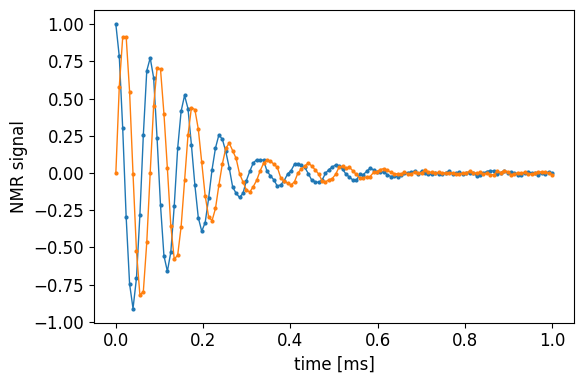

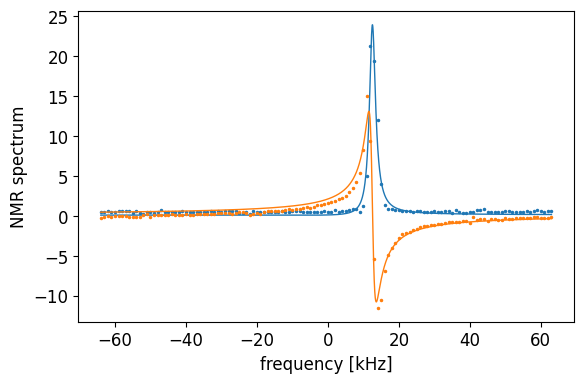

In [8]:
# function definition with two offsets
def lorentzAbsFct(f, f0, A, T2, o):
    return A * T2 / (1 + (f-f0)**2 * T2**2) + o
def lorentzDisFct(f, f0, A, T2, o):
    return -A * (f-f0) * T2**2 / (1 + (f-f0)**2 * T2**2) + o
def lorentzFct(f, f0, A, T2a, p, oa, od):
    res = lorentzAbsFct(f, f0, A, T2a, oa) + 1.j*lorentzDisFct(f, f0, A, T2a, od)
    res = res*np.exp(-1.j*np.pi*p/180)
    return res
def lorentzFitFct(f, f0, A, T2a, p, oa, od):
    N = len(f)
    f_real = f[:N//2]
    f_imag = f[N//2:]
    y_real = np.real(lorentzFct(f_real, f0, A, T2a, p, oa, od))
    y_imag = np.imag(lorentzFct(f_imag, f0, A, T2a, p, oa, od))
    return np.hstack([y_real, y_imag])

# function definition with one offset
def lorentzAbsFct(f, f0, A, T2, o):
    return A * T2 / (1 + (f-f0)**2 * T2**2) + o
def lorentzDisFct(f, f0, A, T2, o):
    return -A * (f-f0) * T2**2 / (1 + (f-f0)**2 * T2**2) + o
def lorentzFct(f, f0, A, T2a, p, oa):
    res = lorentzAbsFct(f, f0, A, T2a, oa) + 1.j*lorentzDisFct(f, f0, A, T2a, oa)
    res = res*np.exp(-1.j*np.pi*p/180)
    return res
def lorentzFitFct(f, f0, A, T2a, p, oa):
    N = len(f)
    f_real = f[:N//2]
    f_imag = f[N//2:]
    y_real = np.real(lorentzFct(f_real, f0, A, T2a, p, oa))
    y_imag = np.imag(lorentzFct(f_imag, f0, A, T2a, p, oa))
    return np.hstack([y_real, y_imag])

relaxationTime = lambda t, P0, T2, A: P0 * np.exp(-t/T2) + A

file = 'data/nmrSignal_reference.txt'

specWidth = 1e3*128
tdwell = 1/specWidth

print('dwell time:', tdwell)

sig = pd.read_csv(file, skiprows=12)
sig = (np.asarray(sig['[DATA]'][::2]) + 1.j*np.asarray(sig['[DATA]'][1::2]))

time = np.linspace(0, len(sig)*tdwell, len(sig))

phase = 20
sig = sig * np.exp(-1.j*np.pi*phase/180)

sig = sig/sig.max()



popt = (np.abs(sig).max(), 1e-4, 0)
popt, pcov = curve_fit(relaxationTime, time, np.abs(sig), p0=popt)
perr = np.sqrt(np.diag(pcov))
print(popt[1]*1e6, perr[1]*1e6)
    
freq = np.fft.fftshift(np.fft.fftfreq(len(sig), d=tdwell))
spec = np.fft.fftshift(np.fft.fft(sig, n=len(sig), norm='backward'))
noise = spec[:len(spec)//2].real.std()
idx_max = int(nmrConfig['idx_res'])
popt = (freq[idx_max],1e3*spec[idx_max].real,0.001,0,0)

popt, pcov = curve_fit(lorentzFitFct, np.hstack([freq,freq]), np.hstack([spec.real, spec.imag]), sigma=noise*np.ones(2*len(spec)), absolute_sigma=True, p0=popt, maxfev=100000)
perr = np.sqrt(np.diag(pcov))
chi2 = np.sum((np.hstack([spec.real, spec.imag])-lorentzFitFct(np.hstack([freq,freq]), *popt))**2 / (noise*np.ones(2*len(spec)))**2)
chi2_r = chi2 / (2*len(spec) - len(popt))

print('reduced chi-squared: {:.2f}\n'.format(chi2_r))

freqFit = np.linspace(freq.min(), freq.max(), 10001)

with plt.rc_context(paperStyle):
    
    fig, ax = plt.subplots()
    ax.plot(time*1e3, sig.real, 'C0.-', ms=4, lw=1)
    ax.plot(time*1e3, sig.imag, 'C1.-', ms=4, lw=1)
    ax.set(xlabel='time [ms]', ylabel='NMR signal')
    fig.set(dpi=100)
    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot(freq/1e3, spec.real, 'C0.', ms=3)
    ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).real, 'C0-', lw=1)    
    ax.plot(freq/1e3, spec.imag, 'C1.', ms=3)
    ax.plot(freqFit/1e3, lorentzFct(freqFit, *popt).imag, 'C1-', lw=1)
    ax.set(xlabel='frequency [kHz]', ylabel='NMR spectrum')
    fig.set(dpi=100)
    fig.tight_layout()
    plt.show()